In [154]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl
import copy

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

In [155]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "./datasets/",
    shuffle = True,
    batch_size = 32,
    image_size = (160,160),
    validation_split = .2,
    subset = "training",
    seed = 43
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "./datasets/",
    shuffle = True,
    batch_size = 32,
    image_size = (160,160),
    validation_split = .2,
    subset = "validation",
    seed = 43
)

Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


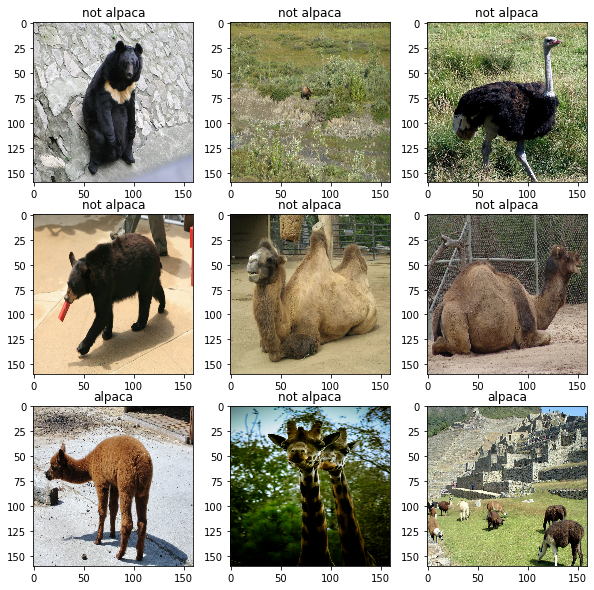

In [156]:
classes = train_dataset.class_names
_a = list(train_dataset.as_numpy_iterator())
# Because the datasets has already been shuffled when loading form directory
# no randomization is necessary for depicting images
# img, ax = plt.subplots(3,3)
i = 0
fig = plt.figure(figsize=(10,10))
for batch in _a:
    # Only get tha first batch
    img = batch[0]
    labels = batch[1]
    for i in range(9):
        # if i == 1: break
        plt.subplot(3,3,i+1)
        plt.imshow(img[i][:].astype("uint8"))
        plt.title(f"{classes[labels[i]]}")
    break
plt.show()

In [157]:
# Real-time data augmentation
def data_augmenter():
    """
    Creates a sequential model for augmenting incoming data
    """
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'))
    data_augmentation.add(tf.keras.layers.experimental.preprocessing.RandomRotation(0.2))

    return data_augmentation

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)


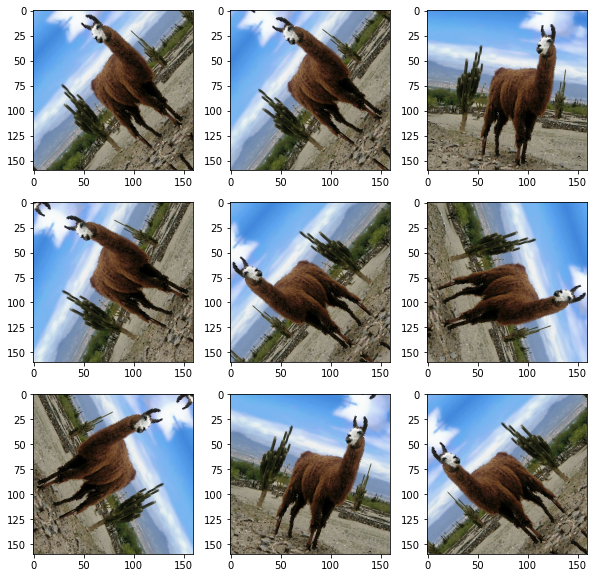

In [185]:
# Data augmentation example
augmenter = data_augmenter()

# Choose a random image
_a = list(train_dataset.as_numpy_iterator())
batch = _a[np.random.randint(0,9)]
img = batch[0][np.random.randint(0, len(batch[0]))]

fig = plt.figure(figsize = (10,10))

for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(augmenter(img).numpy().astype("uint8"))

plt.show()

In [188]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
IMG_SHAPE = (160, 160) + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')
base_model.summary()

14536120/14536120 [==============================] - 39s 3us/step
Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_2[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (

In [195]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)


In [193]:
base_model.trainable = False
image_var = tf.Variable(preprocess_input(image_batch))
pred = base_model(image_var)

tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)

35363/35363 [==============================] - 0s 3us/step


[[('n02095570', 'Lakeland_terrier', 0.3748357),
  ('n02090721', 'Irish_wolfhound', 0.09703056)],
 [('n02093647', 'Bedlington_terrier', 0.41184512),
  ('n02104029', 'kuvasz', 0.152815)],
 [('n02437616', 'llama', 0.30917057),
  ('n02093647', 'Bedlington_terrier', 0.19013952)],
 [('n02128925', 'jaguar', 0.61840963), ('n02128385', 'leopard', 0.020847335)],
 [('n02480855', 'gorilla', 0.08541757),
  ('n02481823', 'chimpanzee', 0.047643907)],
 [('n01518878', 'ostrich', 0.96526086),
  ('n02018795', 'bustard', 0.0018524198)],
 [('n02132136', 'brown_bear', 0.3295382), ('n02410509', 'bison', 0.14310616)],
 [('n02437616', 'llama', 0.08033925),
  ('n02097130', 'giant_schnauzer', 0.05821674)],
 [('n02437312', 'Arabian_camel', 0.9271188),
  ('n02422106', 'hartebeest', 0.003943339)],
 [('n02437616', 'llama', 0.736892),
  ('n02090721', 'Irish_wolfhound', 0.03740289)],
 [('n01518878', 'ostrich', 0.95788074),
  ('n02018795', 'bustard', 0.0029069418)],
 [('n02130308', 'cheetah', 0.25031042),
  ('n02128757

In [198]:
def alpaca_model(image_shape=(160,160), data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''
    
    
    input_shape = image_shape + (3,)
    
    ### START CODE HERE
    
    base_model = tf.keras.applications.MobileNetV2(input_shape = input_shape,
                                                   include_top = False, # <== Important!!!!
                                                   weights = "imagenet") # From imageNet
    
    # freeze the base model by making it non trainable
    base_model.trainable = False 

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(input_shape) 
    
    # apply data augmentation to the inputs
    x = data_augmentation(inputs)
    
    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x) 
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    
    # add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tf.keras.layers.GlobalAveragePooling2D()(x) 
    # include dropout with probability of 0.2 to avoid overfitting
    x = tf.keras.layers.Dropout(rate = .2)(x)
        
    # use a prediction layer with one neuron (as a binary classifier only needs one)
    outputs = tf.keras.layers.Dense(units = 1)(x)
    
    ### END CODE HERE
    
    model = tf.keras.Model(inputs, outputs)
    
    return model

model2 = alpaca_model((160,160), augmenter)

9406464/9406464 [==============================] - 5s 1us/step


In [200]:
base_learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [201]:
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5
9/9 [==============================] - 6s 373ms/step - loss: 0.8481 - accuracy: 0.4885 - val_loss: 0.7125 - val_accuracy: 0.4462
Epoch 2/5
9/9 [==============================] - 3s 269ms/step - loss: 0.6934 - accuracy: 0.5687 - val_loss: 0.5741 - val_accuracy: 0.6308
Epoch 3/5
9/9 [==============================] - 3s 286ms/step - loss: 0.5725 - accuracy: 0.6985 - val_loss: 0.4753 - val_accuracy: 0.7385
Epoch 4/5
9/9 [==============================] - 3s 283ms/step - loss: 0.5024 - accuracy: 0.7634 - val_loss: 0.4455 - val_accuracy: 0.7077
Epoch 5/5
9/9 [==============================] - 3s 265ms/step - loss: 0.4727 - accuracy: 0.6985 - val_loss: 0.3937 - val_accuracy: 0.7846


In [202]:
# UNQ_C3
base_model = model2.layers[4]
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 120

### START CODE HERE

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
# Define a BinaryCrossentropy loss function. Use from_logits=True
loss_function=tf.keras.losses.BinaryCrossentropy(from_logits=True)
# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(.1*base_learning_rate)
# Use accuracy as evaluation metric
metrics=["accuracy"]

### END CODE HERE

model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

Number of layers in the base model:  154


In [203]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/10
9/9 [==============================] - 9s 401ms/step - loss: 0.5050 - accuracy: 0.7328 - val_loss: 0.2921 - val_accuracy: 0.8615
Epoch 6/10
9/9 [==============================] - 3s 311ms/step - loss: 0.2682 - accuracy: 0.9160 - val_loss: 0.2251 - val_accuracy: 0.8769
Epoch 7/10
9/9 [==============================] - 3s 340ms/step - loss: 0.2017 - accuracy: 0.9160 - val_loss: 0.1920 - val_accuracy: 0.8923
Epoch 8/10
9/9 [==============================] - 3s 350ms/step - loss: 0.1495 - accuracy: 0.9122 - val_loss: 0.2007 - val_accuracy: 0.9231
Epoch 9/10
9/9 [==============================] - 4s 362ms/step - loss: 0.1834 - accuracy: 0.9122 - val_loss: 0.1578 - val_accuracy: 0.9231
Epoch 10/10
9/9 [==============================] - 3s 341ms/step - loss: 0.1547 - accuracy: 0.9351 - val_loss: 0.1947 - val_accuracy: 0.9077
